## KCC Meeting metadata EDA

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

# Load JSONL file into a DataFrame
file_path = '../data/meetings/meetings_metadata_new.jsonl'
data = pd.read_json(file_path, lines=True)

# Show basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   web_meeting_code   83 non-null     int64         
 1   meeting_id         83 non-null     object        
 2   scrape_timestamp   83 non-null     object        
 3   error              26 non-null     object        
 4   meeting_title      57 non-null     object        
 5   meeting_status     57 non-null     object        
 6   committee_name     57 non-null     object        
 7   meeting_date       57 non-null     object        
 8   meeting_time       57 non-null     datetime64[ns]
 9   agenda_items       57 non-null     object        
 10  header_pdf_urls    57 non-null     object        
 11  attached_pdfs      57 non-null     float64       
 12  header_pdfs        57 non-null     float64       
 13  total_pdfs_found   57 non-null     float64       
 14  pdfs_unassig

#### Loading the metadata and examining the scraping results

In [179]:
# Show the first few rows
#data.head(1)

removing duplicates

In [180]:
# Find duplicated web_meeting_codes
duplicate_codes = data[data['web_meeting_code'].duplicated(keep=False)]

# Sort and select specific columns
duplicate_codes = duplicate_codes.sort_values('web_meeting_code')[
    ['web_meeting_code', 'scrape_timestamp', 'meeting_title', 'meeting_status', 'meeting_date']
]
duplicate_codes.head(10)

,web_meeting_code,scrape_timestamp,meeting_title,meeting_status,meeting_date


In [181]:
# Drop duplicates by web_meeting_code, keeping the last entry
#data = data.sort_values('scrape_timestamp')  # Ensure correct ordering
data = data.drop_duplicates(subset='web_meeting_code', keep='last')

In [182]:
assert data['web_meeting_code'].duplicated().sum() == 0  # Should be 0

checking for missing values

In [183]:
# Column names
print("Columns:", data.columns.tolist())

# Null values
print("\nMissing values per column:\n", data.isnull().sum())

# Unique values per column
print("\nUnique values per column:")
for col in data.columns:
    try:
        unique_count = data[col].nunique()
        print(f"{col}: {unique_count}")
    except TypeError:
        print(f"{col}: ❌ Cannot count unique values (unhashable type like list or dict)")
        
# If 'meeting_date' exists and is string, convert to datetime
if 'meeting_date' in data.columns:
    data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
    print("\nDate range:", data['meeting_date'].min(), "to", data['meeting_date'].max())

Columns: ['web_meeting_code', 'meeting_id', 'scrape_timestamp', 'error', 'meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items', 'header_pdf_urls', 'attached_pdfs', 'header_pdfs', 'total_pdfs_found', 'pdfs_unassigned', 'pdf_attachment_ok']

Missing values per column:
 web_meeting_code      0
meeting_id            0
scrape_timestamp      0
error                57
meeting_title        26
meeting_status       26
committee_name       26
meeting_date         26
meeting_time         26
agenda_items         26
header_pdf_urls      26
attached_pdfs        26
header_pdfs          26
total_pdfs_found     26
pdfs_unassigned      26
pdf_attachment_ok    26
dtype: int64

Unique values per column:
web_meeting_code: 83
meeting_id: 83
scrape_timestamp: 83
error: 1
meeting_title: 57
meeting_status: 1
committee_name: 18
meeting_date: 55
meeting_time: 7
agenda_items: ❌ Cannot count unique values (unhashable type like list or dict)
header_pdf_urls: ❌ Cannot cou

In [184]:
# Convert meeting_date to datetime if not already
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Drop rows where meeting_date is NaT
data = data.dropna(subset=['meeting_date'])

Missing codes: 23


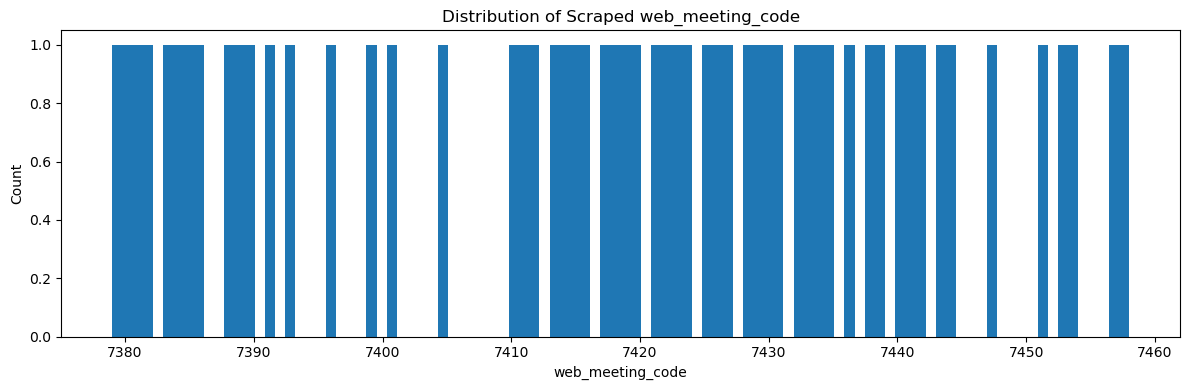

In [185]:
codes = data['web_meeting_code'].dropna().astype(int)
code_range = pd.Series(range(codes.min(), codes.max() + 1))

missing_codes = code_range[~code_range.isin(codes)]
print(f"Missing codes: {len(missing_codes)}")

plt.figure(figsize=(12, 4))
codes.plot(kind='hist', bins=100)
plt.title('Distribution of Scraped web_meeting_code')
plt.xlabel('web_meeting_code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_44836/1028356808.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_44836/1028356808.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=data['scrape_minute'].min(),


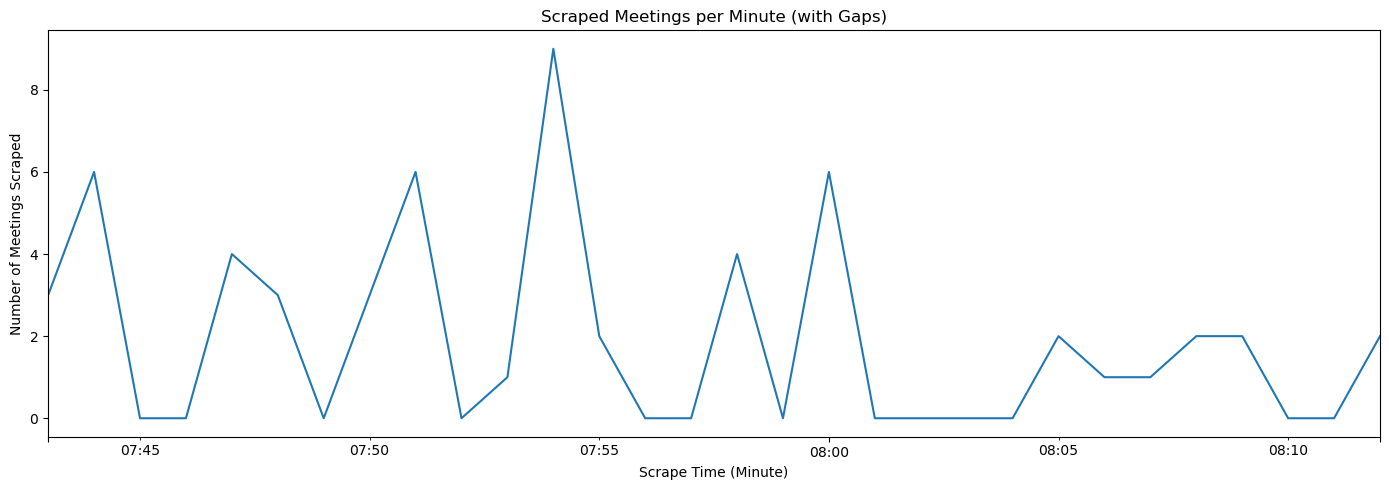

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime
data['scrape_timestamp'] = pd.to_datetime(data['scrape_timestamp'], errors='coerce')

# Floor to minute
data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')

# Count scrapes per minute
scrape_counts = data['scrape_minute'].value_counts().sort_index()

# Create full range of minutes between first and last scrape
full_range = pd.date_range(start=data['scrape_minute'].min(),
                           end=data['scrape_minute'].max(),
                           freq='T')

# Reindex with full range, fill missing with 0
scrape_counts_full = scrape_counts.reindex(full_range, fill_value=0)

# Plot
plt.figure(figsize=(14, 5))
scrape_counts_full.plot()
plt.title('Scraped Meetings per Minute (with Gaps)')
plt.xlabel('Scrape Time (Minute)')
plt.ylabel('Number of Meetings Scraped')
plt.tight_layout()
plt.show()

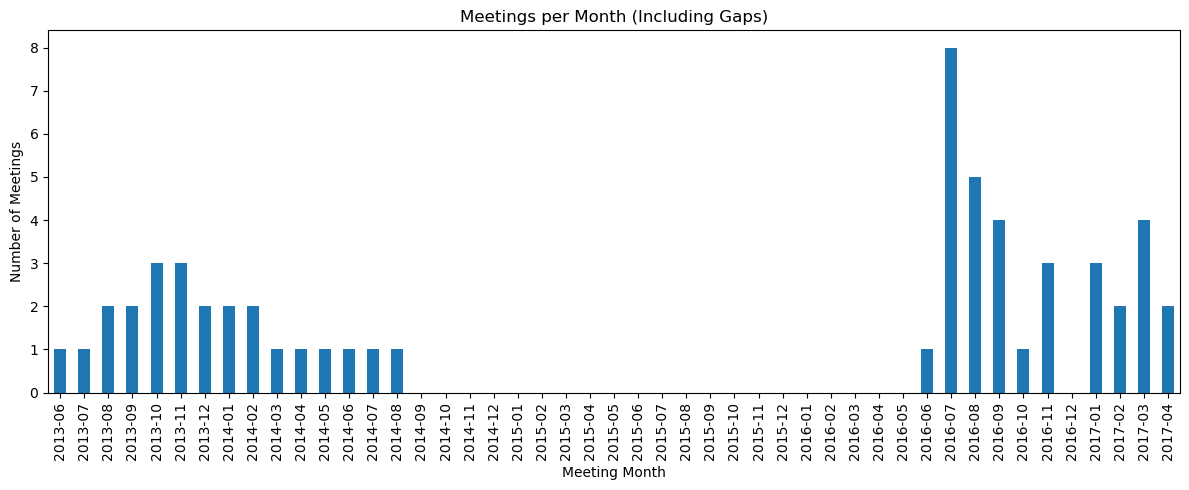

In [187]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert and extract meeting_month
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
data['meeting_month'] = data['meeting_date'].dt.to_period('M')

# Count meetings per month
monthly_counts = data['meeting_month'].value_counts().sort_index()

# Create full continuous monthly index
full_index = pd.period_range(start=data['meeting_month'].min(),
                             end=data['meeting_month'].max(),
                             freq='M')

# Reindex to ensure gaps are shown with 0s
monthly_counts_full = monthly_counts.reindex(full_index, fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
monthly_counts_full.plot(kind='bar')
plt.title('Meetings per Month (Including Gaps)')
plt.xlabel('Meeting Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [188]:
missing_months = data[data['meeting_month'].isna()]
#missing_months.sample(2)

In [189]:
missing_month_count = data['meeting_month'].isna().sum()
print(f"Missing meeting_month values: {missing_month_count}")

Missing meeting_month values: 0


In [190]:
missing_dates = data[data['meeting_date'].isna()]
missing_dates[['meeting_id', 'meeting_title', 'committee_name', 'meeting_date']]

,meeting_id,meeting_title,committee_name,meeting_date


In [191]:
# Define the fields you consider essential
essential_fields = ['meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items']

# Filter rows where web_meeting_code exists AND any essential field is missing
incomplete_rows = data[
    data['web_meeting_code'].notna() & 
    data[essential_fields].isnull().any(axis=1)
]

print(len(incomplete_rows))
incomplete_rows

0


,web_meeting_code,meeting_id,scrape_timestamp,error,meeting_title,meeting_status,committee_name,meeting_date,meeting_time,agenda_items,header_pdf_urls,attached_pdfs,header_pdfs,total_pdfs_found,pdfs_unassigned,pdf_attachment_ok,scrape_minute,meeting_month


In [192]:
rerun = incomplete_rows['web_meeting_code'].to_list()
rerun

[]

In [193]:
import pandas as pd

# Ensure codes are integers and sorted
codes = data['web_meeting_code'].dropna().astype(int)
all_codes = pd.Series(range(codes.min(), codes.max() + 1))

# Identify missing codes
missing_codes = all_codes[~all_codes.isin(codes)]

# Group into consecutive ranges
gap_ranges = []
if not missing_codes.empty:
    start = prev = missing_codes.iloc[0]
    for code in missing_codes[1:]:
        if code == prev + 1:
            prev = code
        else:
            gap_ranges.append((start, prev))
            start = prev = code
    gap_ranges.append((start, prev))  # add final group

# Create DataFrame of missing ranges
missing_df = pd.DataFrame(gap_ranges, columns=['missing_start', 'missing_end'])
missing_df['missing_count'] = missing_df['missing_end'] - missing_df['missing_start'] + 1

missing_df.sort_values(by=['missing_count'], ascending=False).head(15)

,missing_start,missing_end,missing_count
6,7406,7409,4
5,7402,7404,3
9,7448,7450,3
2,7394,7395,2
3,7397,7398,2
8,7445,7446,2
11,7455,7456,2
0,7387,7387,1
1,7392,7392,1
4,7400,7400,1


In [194]:
# Ensure meeting_date is datetime
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Create a Year-Month string column
data['year_month'] = data['meeting_date'].dt.to_period('M').astype(str)

# Group by year_month and get min, max, and count of web_meeting_code
grouped = data.groupby('year_month')['web_meeting_code'].agg(['min', 'max', 'count']).reset_index()

# Sort by month
grouped = grouped.sort_values('year_month')
grouped.tail(10)

,year_month,min,max,count
15,2016-06,7379,7379,1
16,2016-07,7380,7401,8
17,2016-08,7381,7451,5
18,2016-09,7453,7458,4
19,2016-10,7385,7385,1
20,2016-11,7386,7390,3
21,2017-01,7434,7436,3
22,2017-02,7438,7439,2
23,2017-03,7388,7441,4
24,2017-04,7442,7443,2


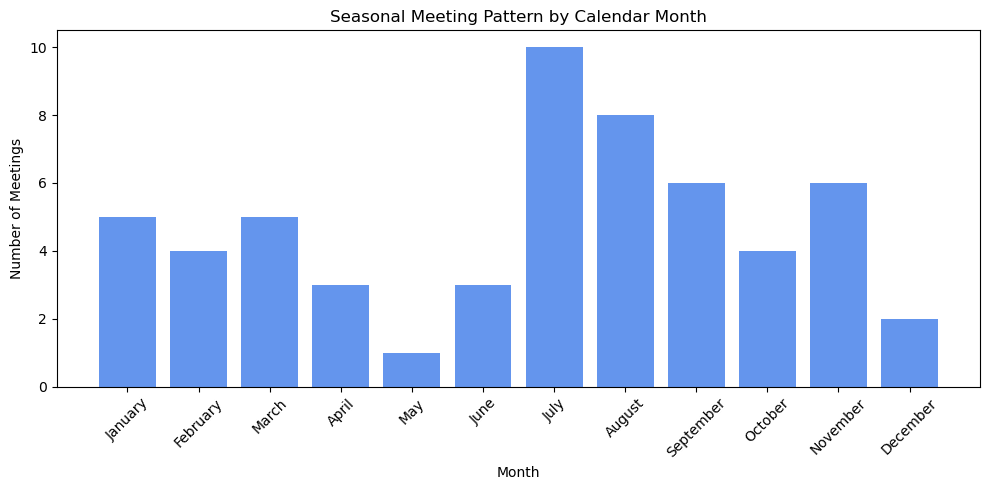

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is parsed
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Extract numeric month (1–12) and month name
data['month'] = data['meeting_date'].dt.month
data['month_name'] = data['meeting_date'].dt.month_name()

# Group by month number and count meetings
monthly_pattern = data.groupby(['month', 'month_name']).size().reset_index(name='count')

# Sort by calendar order
monthly_pattern = monthly_pattern.sort_values('month')

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_pattern['month_name'], monthly_pattern['count'], color='cornflowerblue')
plt.title('Seasonal Meeting Pattern by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [196]:
# Show a few non-empty agenda items
data['agenda_items'].dropna().iloc[0:1].tolist()

[[{'item_number': '1',
   'item_title': 'Substitutes',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 1.',
     'pdf_urls': []}],
   'pdf_urls': []},
  {'item_number': '2',
   'item_title': 'Declarations of Interest on any items on this agenda',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 2.',
     'pdf_urls': []}],
   'pdf_urls': []},
  {'item_number': '3',
   'item_title': 'Minutes - 22 May 2015PDF 65 KB',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 3.',
     'pdf_urls': []}],
   'pdf_urls': ['https://democracy.kent.gov.uk/documents/s67450/Minutes of Previous Meeting.pdf']},
  {'item_number': '4',
   'item_title': 'Motion to Exclude the Press and Public',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 4.',
     'pdf_urls': []}],
   'pdf_urls': []},
  {'item_number': '5',
   'item_title': 'County Returning Officer',
   'sub_items': [],
   'pdf_u

#### Cleanup of junk pdf scraping results

In [197]:
import re

def clean_item_title(title):
    if isinstance(title, str):
        return re.sub(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', '', title, flags=re.IGNORECASE).strip()
    return title

def clean_agenda_items(items):
    if isinstance(items, list):
        for item in items:
            if isinstance(item, dict) and 'item_title' in item:
                item['item_title'] = clean_item_title(item['item_title'])
    return items

# Apply cleaning to the full DataFrame
data['agenda_items'] = data['agenda_items'].apply(clean_agenda_items)

#### Explore agendas

In [198]:
#### code to explode 3 tier structure - new scraping code

import pandas as pd
import json

def flatten_agenda_from_df(data):
    # Step 1: Explode agenda_items so each item gets its own row
    agenda_data = data.explode('agenda_items').dropna(subset=['agenda_items']).copy()
    agenda_items_df = pd.json_normalize(agenda_data['agenda_items'])

    # Step 2: Merge back meeting context
    agenda_items_df['meeting_id'] = agenda_data['meeting_id'].values
    agenda_items_df['committee_name'] = agenda_data['committee_name'].values
    agenda_items_df['meeting_date'] = agenda_data['meeting_date'].values
    agenda_items_df['web_meeting_code'] = agenda_data['web_meeting_code'].values

    # OPTIONAL: Append meeting-wide QA flags to every row
    agenda_items_df['pdf_attachment_ok'] = agenda_data.get('pdf_attachment_ok', False).values
    agenda_items_df['attached_pdfs'] = agenda_data.get('attached_pdfs', 0).values
#    agenda_items_df['pdfs_unassigned'] = agenda_data.get('pdfs_unassigned', 0).values

    # Step 3: Explode sub_items (if any)
    agenda_items_df['sub_items'] = agenda_items_df.get('sub_items', None)
    agenda_items_df = agenda_items_df.explode('sub_items')

    # Step 4: Fill sub_item fields (or fallback to item level)
    agenda_items_df['sub_item_content'] = agenda_items_df['sub_items'].apply(
        lambda x: x.get('title') if isinstance(x, dict) else None
    )
    agenda_items_df['item_text'] = agenda_items_df['sub_items'].apply(
        lambda x: x.get('content') if isinstance(x, dict) else None
    )

    agenda_items_df['item_text'] = agenda_items_df['item_text'].fillna(agenda_items_df.get('content', ''))
    agenda_items_df['pdf_urls'] = agenda_items_df.apply(
        lambda row: row['sub_items'].get('pdf_urls') if isinstance(row['sub_items'], dict) and row['sub_items'].get('pdf_urls') else row.get('pdf_urls', []),
        axis=1
    )

    # Final output
    agenda_flat = agenda_items_df[[
        'meeting_id', 'committee_name', 'meeting_date', 'web_meeting_code',
        'item_number', 'item_title', 'item_text', 'pdf_urls', 'sub_item_content'
    ]].copy()

    return agenda_flat

# Usage
agenda_flat = flatten_agenda_from_df(data)

In [199]:
#### code to explode 2 tier structure - the old scraping code

#import pandas as pd

# Explode agenda_items so each item gets its own row
#agenda_data = data.explode('agenda_items').dropna(subset=['agenda_items']).copy()

# Flatten the nested dictionaries into columns
#agenda_flat = pd.json_normalize(agenda_data['agenda_items'])

# Add meeting context to each item
#agenda_flat['meeting_id'] = agenda_data['meeting_id'].values
#agenda_flat['committee_name'] = agenda_data['committee_name'].values
#agenda_flat['meeting_date'] = agenda_data['meeting_date'].values

# Preview
#agenda_flat.head()

In [200]:
agenda_flat.groupby('meeting_id').size().sort_values(ascending=False)

meeting_id
kent_cc_7443    23
kent_cc_7435    22
kent_cc_7457    21
kent_cc_7451    20
kent_cc_7396    20
kent_cc_7447    18
kent_cc_7380    16
kent_cc_7444    15
kent_cc_7381    14
kent_cc_7401    12
kent_cc_7458    11
kent_cc_7441    10
kent_cc_7454    10
kent_cc_7453     9
kent_cc_7393     8
kent_cc_7384     8
kent_cc_7383     8
kent_cc_7442     8
kent_cc_7436     7
kent_cc_7434     6
kent_cc_7405     6
kent_cc_7440     5
kent_cc_7439     5
kent_cc_7379     5
kent_cc_7399     2
dtype: int64

In [201]:
agenda_flat['item_title'].str.lower().str.extract(r'(\w+)')[0].value_counts().head(20)

0
appeal          134
minutes          15
update            8
disposal          8
review            7
application       6
external          6
internal          6
proposal          6
matters           5
declarations      5
treasury          4
apologies         4
election          4
committee         4
general           3
other             3
motion            3
membership        2
revised           2
Name: count, dtype: int64

In [202]:
# Flatten the list of all pdf URLs
all_pdfs = [url for sublist in agenda_flat['pdf_urls'] if isinstance(sublist, list) for url in sublist]

# Convert to Series for easier analysis
pdf_series = pd.Series(all_pdfs)

# Count total and duplicate entries
total_pdfs = pdf_series.size
unique_pdfs = pdf_series.nunique()
duplicate_pdfs = total_pdfs - unique_pdfs

print(f"Total PDF URLs: {total_pdfs}")
print(f"Unique PDF URLs: {unique_pdfs}")
print(f"Duplicate PDF URLs: {duplicate_pdfs}")

Total PDF URLs: 139
Unique PDF URLs: 91
Duplicate PDF URLs: 48


### New committee cleanup approach

In [203]:
# Count occurrences of each committee_name
committee_counts = data['committee_name'].value_counts(dropna=False)

# Display result
committee_counts.tail(10)

committee_name
Kent and Medway NHS Joint Overview and Scrutiny Committee                                                           1
Kent Utilities Engagement Sub-Committee                                                                             1
Electoral and Boundary Review Committee                                                                             1
Property Sub-Committee                                                                                              1
Neighbourhood Forum Grants meeting, Gravesham East Neighbourhood Forum                                              1
Neighbourhood Forum Grants meeting, Northfleet & Gravesend West Neighbourhood Forum                                 1
Village Greens and Parking, Gravesham Rural Forum                                                                   1
Update on Ebbsfleet Garden City and Launch of 2016 Forum Grants, Northfleet & Gravesend West Neighbourhood Forum    1
Parking, Gravesham East Neighbourhood For

In [204]:
# Create DataFrame from unique non-null committee names
committee_series = data['committee_name'].dropna().unique()
df_committee_parts = pd.DataFrame({'original_name': committee_series})

# Adjust split logic
df_committee_parts['first_part'] = df_committee_parts['original_name'].apply(
    lambda x: x.rsplit(',', 1)[0] if ',' in x else None
)
df_committee_parts['last_part'] = df_committee_parts['original_name'].apply(
    lambda x: x.rsplit(',', 1)[1].strip() if ',' in x else x
)

df_committee_parts.tail(3)

,original_name,first_part,last_part
15,Regulation Committee,None,Regulation Committee
16,Governor Appointments Panel,None,Governor Appointments Panel
17,Selection and Member Services Committee,None,Selection and Member Services Committee


In [205]:
# Define a function to extract the new committee name
def extract_last_part(name):
    if pd.isna(name):
        return name
    return name.rsplit(',', 1)[1].strip() if ',' in name else name

# Apply the transformation back to data, overwriting it
data['committee_name'] = data['committee_name'].apply(extract_last_part)

In [206]:
# Inspect datatypes and nested objects
print(data.dtypes)

# Optional: check a sample problematic row
sample = data.sample(1)
print(sample.to_dict())

web_meeting_code              int64
meeting_id                   object
scrape_timestamp     datetime64[ns]
error                        object
meeting_title                object
meeting_status               object
committee_name               object
meeting_date         datetime64[ns]
meeting_time         datetime64[ns]
agenda_items                 object
header_pdf_urls              object
attached_pdfs               float64
header_pdfs                 float64
total_pdfs_found            float64
pdfs_unassigned             float64
pdf_attachment_ok           float64
scrape_minute        datetime64[ns]
meeting_month             period[M]
year_month                   object
month                         int32
month_name                   object
dtype: object
{'web_meeting_code': {53: 7429}, 'meeting_id': {53: 'kent_cc_7429'}, 'scrape_timestamp': {53: Timestamp('2025-05-19 07:55:16.587402')}, 'error': {53: None}, 'meeting_title': {53: 'Regulation Committee Appeal Panel (Transport) - Mo

### New agenda cleanup approach

Cell 1: Clean PDF garbage from titles

In [207]:
import re

PDF_PATTERN = re.compile(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', flags=re.IGNORECASE)

agenda_flat['item_title'] = agenda_flat['item_title'].fillna('').apply(
    lambda x: PDF_PATTERN.sub('', x).strip()
)

In [208]:
# Word count from item_text
agenda_flat['word_count'] = agenda_flat['item_text'].fillna('').apply(lambda x: len(str(x).split()))

# Count number of PDFs in the list
agenda_flat['pdf_count'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [209]:
agenda_flat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 182
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   meeting_id        289 non-null    object        
 1   committee_name    289 non-null    object        
 2   meeting_date      289 non-null    datetime64[ns]
 3   web_meeting_code  289 non-null    int64         
 4   item_number       289 non-null    object        
 5   item_title        289 non-null    object        
 6   item_text         289 non-null    object        
 7   pdf_urls          289 non-null    object        
 8   sub_item_content  264 non-null    object        
 9   word_count        289 non-null    int64         
 10  pdf_count         289 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 27.1+ KB


Cell 2: Tag low-value items instead of dropping

In [210]:
# Step 1: Start fresh
agenda_flat["category"] = None

# Step 2: Broad pass – assign 'webcast' based on item_text
agenda_flat.loc[
    agenda_flat["item_text"].str.contains(r"\bWebcast for\b", case=False, na=False),
    "category"
] = "webcast"

# Map regex patterns to category labels
CATEGORY_PATTERNS = [
    ('apologies', re.compile(r'(?i)\bapologies\b')),
    ('declarations', re.compile(r'(?i)declaration[s]? of (interest|disclosable|inter)')),
    ('next_meeting', re.compile(r'(?i)date of next meeting')),
    ('exempt_items', re.compile(r'(?i)exempt ')),
    ('work_programme', re.compile(r'(?i)work programme')),
    ('future_meeting', re.compile(r'(?i)future meeting')),
    ('introduction', re.compile(r'(?i)^introduction')),
    ('substitutes', re.compile(r'(?i)substitutes')),
    ('questions', re.compile(r'(?i)questions')),
#    ('tributes', re.compile(r'(?i)tributes')),
    ('appeal', re.compile(r'(?i)appeal ')),
    ('minutes', re.compile(r'(?i)minutes')),
    ('appointments', re.compile(r'(?i)appointment')),
    ('restricted_items', re.compile(r'(?i)restricted')),
    ('election', re.compile(r'(?i)election of')),
    ('future_meeting', re.compile(r'(?i)Date of next')),
    ('exempt_items', re.compile(r'(?i)THE PRESS AND PUBLIC')),
    ('pay_policy', re.compile(r'(?i)Pay Policy')),
    ('welcome', re.compile(r'(?i)Welcome')),
    ('procedural', re.compile(r'(?i)MATTERS FOR DECISION')),  
    ('procedural', re.compile(r'(?i)Dates')),  
    ('performance', re.compile(r'(?i)Performance Report')),  

#    ('online_attendance', re.compile(r'(?i)Virtual Attendance'))
]

# Category assignment function
def classify_category(title):
    title = str(title).lower().strip()
    for label, pattern in CATEGORY_PATTERNS:
        if pattern.search(title):
            return label
    return None  # Explicitly return None if no match

# Apply classification only if category not already set
def classify_category(title):
    title = str(title).lower().strip()
    for label, pattern in CATEGORY_PATTERNS:
        if pattern.search(title):
            return label
    return None  # Do not assign 'discussion' here


# Step 3: Apply regex classification — only overwrite if pattern matches
refined = agenda_flat["item_title"].apply(classify_category)

# Only overwrite where a pattern matched (non-null result)
agenda_flat.loc[refined.notnull(), "category"] = refined[refined.notnull()]

agenda_flat["category"] = agenda_flat["category"].fillna("discussion")


In [211]:
agenda_flat.loc[agenda_flat['category'] == 'discussion', ['item_title', 'item_text', "word_count", "pdf_urls"]].sample(2)

,item_title,item_text,word_count,pdf_urls
85,Review of the Committee's Terms of Reference,(1)The Head of Internal Audit\r\nreported that the annual review of the Committee’s Terms of\r\nReference had resulted in no amendments being proposed.(2)RESOLVED\r\nthat approval be given to the continuation of the Committee’s\r\nTerms of Reference as set out in the Appendix to the report.\n,45,[https://democracy.kent.gov.uk/documents/s74703/Item 14 Review of the Committees Terms of Reference.pdf]
56,2.,2.,1,[]


In [212]:
# Group by category and aggregate
category_counts = agenda_flat.groupby('category').agg(
    count=('category', 'count'),
    avg_word_count=('word_count', 'mean'),
    avg_pdf_count=('pdf_count', 'mean')
).reset_index()

# Optional: round for readability
category_counts['avg_word_count'] = category_counts['avg_word_count'].round(1)
category_counts['avg_pdf_count'] = category_counts['avg_pdf_count'].round(2)

category_counts

,category,count,avg_word_count,avg_pdf_count
0,apologies,4,6.8,0.00
1,appeal,134,9.4,0.00
2,appointments,2,19.5,1.00
3,declarations,5,3.6,0.00
4,discussion,82,100.0,0.90
5,election,4,13.8,0.00
6,exempt_items,3,19.7,0.00
7,future_meeting,2,12.0,0.00
8,minutes,15,44.5,1.27
9,questions,1,12.0,0.00


In [213]:
# Match titles that start with any number (with optional decimal), followed by a dot
pattern = r'^\d+(\.\d+)?\.'

matches = agenda_flat[agenda_flat['item_title'].str.match(pattern, na=False)]

# Display useful fields
#matches[['agenda_id', 'item_title', 'item_text', 'meeting_id']]

In [214]:
matches = agenda_flat[agenda_flat['meeting_id'].str.contains('5703', na=False)]

# Display relevant fields
matches[['meeting_id', 'item_number', 'item_title', 'item_text', 'pdf_urls']]

,meeting_id,item_number,item_title,item_text,pdf_urls


In [215]:
import re

def remove_pdf_lines(text):
    if not isinstance(text, str):
        return text
    # Remove any full line containing ".pdf" (case-insensitive), including trailing linebreaks
    cleaned_lines = [
        line for line in text.splitlines()
        if not re.search(r'\.pdf', line, re.IGNORECASE)
    ]
    return "\n".join(cleaned_lines).strip()

# Apply to the column
agenda_flat["item_text"] = agenda_flat["item_text"].apply(remove_pdf_lines)

In [216]:
agenda_flat[agenda_flat["item_text"].str.contains(r'\.pdf', case=False, na=False)].head(5)

,meeting_id,committee_name,meeting_date,web_meeting_code,item_number,item_title,item_text,pdf_urls,sub_item_content,word_count,pdf_count,category


In [217]:
agenda_flat[agenda_flat["category"] == "webcast"].sample(5)

,meeting_id,committee_name,meeting_date,web_meeting_code,item_number,item_title,item_text,pdf_urls,sub_item_content,word_count,pdf_count,category
79,kent_cc_7435,Governance and Audit Committee,2017-01-25,7435,5,Treasury Management six month review 2016-17,Webcast for 5.,[https://democracy.kent.gov.uk/documents/s74696/Item 08 Treasury Management six month review 2016-17.pdf],Additional documents:,3,1,webcast
48,kent_cc_7396,Property Sub-Committee,2016-07-08,7396,74,"New Ways of Working Programme - Refurbishment of Avenue of Remembrance, Sittingbourne, and St Peter's House, Broadstairs (16/00044a.2 and 44b.2)",Webcast for 74.,"[https://democracy.kent.gov.uk/documents/s70014/B1 - PROD NWOW_Avenue of Remembrance_290616_v1.1_BA.pdf, https://democracy.kent.gov.uk/documents/s70015/B1 - PROD NWOW_St Peters House_290616_v1.1_BA.pdf]",Additional documents:,23,2,webcast
61,kent_cc_7401,Kent Utilities Engagement Sub-Committee,2016-07-27,7401,5,Background Information,Webcast for 5.,[https://democracy.kent.gov.uk/documents/s70166/Item 7b Report to Utility Scrutiny Sub Committee 27 July 2016 -FINAL.pdf],Additional documents:,3,1,webcast
52,kent_cc_7396,Property Sub-Committee,2016-07-08,7396,78,"Disposal of parcels of land at Foxwood School, Hythe, Highview School, Folkestone, Chaucer School, Canterbury, Rowhill School, Wilmington and Astor Of Hever School, Maidstone (16/00065)",There are a further 7 documents.View the full list of documents for item 78.\nWebcast for 78.,"[https://democracy.kent.gov.uk/documents/s69879/B4 - Foxwood - site plan.pdf, https://democracy.kent.gov.uk/documents/s69880/B4 - Highview School - site plan.pdf, https://democracy.kent.gov.uk/documents/s69881/B4 - Chaucer school - site plan.pdf, https://democracy.kent.gov.uk/documents/s69882/B4 - Rowhill site plan.pdf, https://democracy.kent.gov.uk/documents/s69883/B4 - Astor of Hever site plan.pdf]",Additional documents:,69,5,webcast
104,kent_cc_7441,Selection and Member Services Committee,2017-03-01,7441,2,Review of Members' Communication and Information Technology (ICT),Webcast for 2.,[https://democracy.kent.gov.uk/documents/s75499/Item 04 Review of Members Information and Communication Technology ICT.pdf],Additional documents:,3,1,webcast


In [218]:
short_items = agenda_flat[agenda_flat['word_count'] < 5]

# Display useful columns
short_items[['item_title', 'item_text', 'word_count', 'category']].sample(10)

,item_title,item_text,word_count,category
8,Appeal 4 - 11.30,NOT UPHELD,2,appeal
150,Appeal 5 - 12.00,NOT UPHELD,2,appeal
177,Appeal 1 - 10am,UPHELD,1,appeal
3,Motion to Exclude the Press and Public,Webcast for 4.,3,exempt_items
171,Appeal 6 - 13.30,NOT UPHELD,2,appeal
173,Appeal 8 - 14.30,NOT UPHELD,2,appeal
78,Review of KCC's Risk Management Policy and Strategy,Webcast for 4.,3,webcast
104,Review of Members' Communication and Information Technology (ICT),Webcast for 2.,3,webcast
147,Appeal 2 - 10.30,NOT UPHELD,2,appeal
165,Appeal 5 - 12.00,NOT UPHELD,2,appeal


Cell 3: Assign fallback item numbers

In [219]:
# Replace missing or blank item_numbers with zero-padded fallback numbers
agenda_flat['item_number'] = agenda_flat['item_number'].fillna('')

agenda_flat['item_number'] = agenda_flat.groupby('meeting_id')['item_number'].transform(
    lambda x: [item if item.strip() else f"{i+1:03d}" for i, item in enumerate(x)]
)

Cell 4: Generate agenda_id

In [220]:
# Step 1: Ensure item_number is a string
agenda_flat['item_number'] = agenda_flat['item_number'].fillna('').astype(str).str.strip()

# Step 2: Sort by meeting_id and item_number alphabetically then numerically
agenda_flat['item_number'] = agenda_flat['item_number'].str.replace(r'[.\s]', '', regex=True)
#agenda_flat['item_number_sort'] = agenda_flat['item_number'].str.extract(r'(\d+)')[0].fillna('').astype(str).str.zfill(3)
#agenda_flat = agenda_flat.sort_values(by=['meeting_id', 'item_number', 'item_number_sort']).reset_index(drop=True)

# Step 3: Assign sequential index within each meeting after sorting
agenda_flat['item_seq'] = agenda_flat.groupby('meeting_id').cumcount() + 1
agenda_flat['item_num_clean'] = agenda_flat['item_seq'].astype(str).str.zfill(3)

# Step 4: Build clean agenda_id
agenda_flat['agenda_id'] = agenda_flat['meeting_id'] + '_' + agenda_flat['item_num_clean']

# Optional: drop the helper column
#agenda_flat.drop(columns=['item_number_sort'], inplace=True)

In [221]:
# Assign machine readable meeting time
#agenda_flat['meeting_date_ts'] = agenda_flat['meeting_date'].astype('int64') // 1_000_000  # milliseconds
#agenda_flat['meeting_date_str'] = agenda_flat['meeting_date'].dt.strftime('%Y-%m-%d')

Reorder columns in agenda_flat

In [222]:
# Desired leading columns
lead_cols = ['meeting_id','agenda_id', 'item_num_clean']#, 'meeting_date_str']

# Get the rest of the columns (preserving order but excluding the leads)
other_cols = [col for col in agenda_flat.columns if col not in lead_cols]

# Reassign agenda_flat with new column order
agenda_flat = agenda_flat[lead_cols + other_cols]

In [223]:
agenda_flat.head(5)

,meeting_id,agenda_id,item_num_clean,committee_name,meeting_date,web_meeting_code,item_number,item_title,item_text,pdf_urls,sub_item_content,word_count,pdf_count,category,item_seq
0,kent_cc_7379,kent_cc_7379_001,001,Electoral and Boundary Review Committee,2016-06-22,7379,1,Substitutes,Webcast for 1.,[],Additional documents:,3,0,substitutes,1
1,kent_cc_7379,kent_cc_7379_002,002,Electoral and Boundary Review Committee,2016-06-22,7379,2,Declarations of Interest on any items on this agenda,Webcast for 2.,[],Additional documents:,3,0,declarations,2
2,kent_cc_7379,kent_cc_7379_003,003,Electoral and Boundary Review Committee,2016-06-22,7379,3,Minutes - 22 May 2015,Webcast for 3.,[https://democracy.kent.gov.uk/documents/s67450/Minutes of Previous Meeting.pdf],Additional documents:,3,1,minutes,3
3,kent_cc_7379,kent_cc_7379_004,004,Electoral and Boundary Review Committee,2016-06-22,7379,4,Motion to Exclude the Press and Public,Webcast for 4.,[],Additional documents:,3,0,exempt_items,4
4,kent_cc_7379,kent_cc_7379_005,005,Electoral and Boundary Review Committee,2016-06-22,7379,5,County Returning Officer,County Returning Officer,[],None,3,0,discussion,5


In [224]:
# Sort agenda items chronologically and by item within each meeting
agenda_flat = agenda_flat.sort_values(by=['meeting_date', 'agenda_id'], ascending=False).reset_index(drop=True)

In [225]:
assert 'meeting_id' in agenda_flat.columns, "meeting_id is missing!"

In [226]:
agenda_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   meeting_id        289 non-null    object        
 1   agenda_id         289 non-null    object        
 2   item_num_clean    289 non-null    object        
 3   committee_name    289 non-null    object        
 4   meeting_date      289 non-null    datetime64[ns]
 5   web_meeting_code  289 non-null    int64         
 6   item_number       289 non-null    object        
 7   item_title        289 non-null    object        
 8   item_text         289 non-null    object        
 9   pdf_urls          289 non-null    object        
 10  sub_item_content  264 non-null    object        
 11  word_count        289 non-null    int64         
 12  pdf_count         289 non-null    int64         
 13  category          289 non-null    object        
 14  item_seq          289 non-

Cell 5: Save to agenda_items.jsonl

In [227]:
output_path = '../data/metadata/agenda_items.jsonl'
agenda_flat.to_json(output_path, orient='records', lines=True)

print(f"✅ Saved {len(agenda_flat)} agenda items to: {output_path}")

✅ Saved 289 agenda items to: ../data/metadata/agenda_items.jsonl


### Saving meetings metadata

In [228]:
# Drop agenda_items column (it is now split into agenda_flat)
meetings_df = data.drop(columns=['agenda_items'])

# Optional: sort by meeting_date
meetings_df = meetings_df.sort_values(by='meeting_date').reset_index(drop=True)

In [229]:
meetings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   web_meeting_code   57 non-null     int64         
 1   meeting_id         57 non-null     object        
 2   scrape_timestamp   57 non-null     datetime64[ns]
 3   error              0 non-null      object        
 4   meeting_title      57 non-null     object        
 5   meeting_status     57 non-null     object        
 6   committee_name     57 non-null     object        
 7   meeting_date       57 non-null     datetime64[ns]
 8   meeting_time       57 non-null     datetime64[ns]
 9   header_pdf_urls    57 non-null     object        
 10  attached_pdfs      57 non-null     float64       
 11  header_pdfs        57 non-null     float64       
 12  total_pdfs_found   57 non-null     float64       
 13  pdfs_unassigned    57 non-null     float64       
 14  pdf_attachme

In [230]:
meetings_df.sample(2)

,web_meeting_code,meeting_id,scrape_timestamp,error,meeting_title,meeting_status,committee_name,meeting_date,meeting_time,header_pdf_urls,attached_pdfs,header_pdfs,total_pdfs_found,pdfs_unassigned,pdf_attachment_ok,scrape_minute,meeting_month,year_month,month,month_name
41,7457,kent_cc_7457,2025-05-19 08:12:13.278253,None,"Regulation Committee Appeal Panel (Transport) - Thursday, 22nd September, 2016 10.00 am",scheduled,Regulation Committee Appeal Panel (Transport),2016-09-22,2025-05-19 10:00:00,[],0.0,0.0,0.0,0.0,1.0,2025-05-19 08:12:00,2016-09,2016-09,9,September
2,7412,kent_cc_7412,2025-05-19 07:51:01.011448,None,"Regulation Committee Appeal Panel (Transport) - Tuesday, 6th August, 2013 10.00 am",scheduled,Regulation Committee Appeal Panel (Transport),2013-08-06,2025-05-19 10:00:00,[],0.0,0.0,0.0,0.0,1.0,2025-05-19 07:51:00,2013-08,2013-08,8,August


In [231]:
# Drop helper columns
meetings_df = meetings_df.drop(columns=['meeting_month', 'month_name','month','error','scrape_minute', "year_month" ])

In [232]:
# Sort by meeting_date descending (most recent first)
meetings_df = meetings_df.sort_values(by='meeting_date', ascending=False).reset_index(drop=True)

### Saving meetings to json

In [233]:
# Save to JSONL
meetings_path = '../data/metadata/meetings.jsonl'
meetings_df.to_json(meetings_path, orient='records', lines=True)

print(f"✅ Saved {len(meetings_df)} meetings to: {meetings_path}")

✅ Saved 57 meetings to: ../data/metadata/meetings.jsonl


### STOP HERE

### Committee and agenda cleaning code (legacy code block - already incorporated above) - IGNORE

In [175]:
import pandas as pd
import re
from functools import lru_cache
import numpy as np

# Constants and compiled patterns
PDF_PATTERN = re.compile(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', flags=re.IGNORECASE)
MINUTES_PATTERN = re.compile(r'(?i)^minutes of the meeting|^minutes for')
JUNK_PATTERNS = [
    re.compile(r'(?i)apologi(es|s)'),
    re.compile(r'(?i)declaration[s]? of (interest|disclosable|inter)'),
    re.compile(r'(?i)date of next meeting'),
    re.compile(r'(?i)exempt items'),
    re.compile(r'(?i)minutes'),
    re.compile(r'(?i)^work programme'),
    re.compile(r'(?i)future meeting'),
    re.compile(r'(?i)^introduction'),
    re.compile(r'(?i)substitutes'),
    re.compile(r'(?i)questions'),
    re.compile(r'(?i)tributes'),
    re.compile(r'(?i)election of')
]

# Committee normalization setup
keyword_map = {
    'county council': 'County Council',
    'kent and medway police and crime panel': 'Kent and Medway Police and Crime Panel',
    'select committee': 'Select Committee',
    'member development': 'Member Development',
    'regulation committee appeal': 'Regulation Committee Appeal Panel (Transport)',
    'standing advisory council on religious': 'Standing Advisory Council on Religious Education (SACRE)',
    'adult social care': 'Adult Social Care Cabinet Committee',
    'pension': 'Pension Fund Committee',
    'education': "Children's, Young People and Education Cabinet Committee",
    'personnel': "Personnel Committee",
    'regulation committee member panel': 'Regulation Committee',
    "children's social care and health cabinet committee": "Children's, Young People and Education Cabinet Committee",
    'environment & transport cabinet committee': "Environment & Transport Cabinet Committee",
    'governance and audit committee': "Governance and Audit Committee",
    'nhs joint': "Kent and Medway NHS Joint Overview and Scrutiny Committee",
    'standards committee': "Standards Committee",
    'wellbeing board': "Kent Health and Wellbeing Board",
    'scrutiny committee': "Scrutiny Committee",
    'governor appointments': "Governor Appointments Panel",
    'regulation committee appeal panel': "Regulation Committee Appeal Panel (Transport)",
    "mental health guardianship": "Regulation Committee"
}

@lru_cache(maxsize=500)
def normalize_committee(name):
    if not isinstance(name, str):
        return name
    name_lower = name.lower()
    for keyword, canonical in keyword_map.items():
        if keyword in name_lower:
            return canonical
    return name

# Cleaning functions
def clean_single_item(item):
    if not isinstance(item, dict):
        return item
    return {
        **item,
        'item_title': PDF_PATTERN.sub('', item.get('item_title', '')).strip()
    }

def is_junk_item(item):
    if not isinstance(item, dict):
        return True
    title = str(item.get('item_title', '')).lower()
    return (
        not title.strip() or
        any(pattern.search(title) for pattern in JUNK_PATTERNS) or
        MINUTES_PATTERN.search(title)
    )

def filter_junk_items(items):
    if not isinstance(items, list):
        return []
    return [item for item in items if not is_junk_item(item)]

def clean_data_chunk(chunk):
    """Helper function for parallel processing"""
    return chunk.assign(agenda_items=chunk['agenda_items'].apply(filter_junk_items))

# Main cleaning pipeline
def clean_data(file_path):
    # Load data
    df = pd.read_json(file_path, lines=True)
    
    # Convert dates
    df['scrape_timestamp'] = pd.to_datetime(df['scrape_timestamp'], errors='coerce')
    df['meeting_date'] = pd.to_datetime(df['meeting_date'], errors='coerce')
    
    # Clean agenda items
    df['agenda_items'] = df['agenda_items'].apply(
        lambda x: [clean_single_item(i) for i in x] if isinstance(x, list) else x
    )
    
    # Normalize committees
    df['committee_name'] = df['committee_name'].apply(normalize_committee)
    df = df[~df['committee_name'].str.contains('forum', case=False, na=False)]
    
    # Filter junk items (sequential version - removed parallel processing)
    df['agenda_items'] = df['agenda_items'].apply(filter_junk_items)
    
    # Final filtering
    df = df[df['agenda_items'].str.len() > 0]
    valid_committees = df['committee_name'].dropna().unique()
    df = df[df['committee_name'].isin(valid_committees)]
    
    return df.reset_index(drop=True)

# View agenda items function
def get_committee_agenda_items(df, committee_name):
    committee_meetings = df[
        df['committee_name'].str.lower() == committee_name.lower()
    ].copy()
    
    if committee_meetings.empty:
        print(f"No meetings found for committee: {committee_name}")
        return pd.DataFrame()
    
    agenda_data = committee_meetings.explode('agenda_items').dropna(subset=['agenda_items'])
    agenda_flat = pd.json_normalize(agenda_data['agenda_items'])
    
    # Add meeting context
    context_cols = ['meeting_id', 'committee_name', 'meeting_date', 'meeting_title']
    for col in context_cols:
        agenda_flat[col] = agenda_data[col].values
    
    agenda_flat['num_pdfs'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    return agenda_flat.sort_values(['meeting_date', 'item_number']).reset_index(drop=True)

# Execute pipeline
if __name__ == "__main__":
    FILE_PATH = '../data/meetings/meetings_metadata.jsonl'
    
    # Clean the data
    cleaned_data = clean_data(FILE_PATH)
    
    # Example usage - view Cabinet items
    cabinet_items = get_committee_agenda_items(cleaned_data, "Governance and Audit Committee")
    print(f"Found {len(cabinet_items)} agenda items for Cabinet")
    
    # Show available committees
    print("\nAvailable committees:")
    print(cleaned_data['committee_name'].unique())
    
    # Uncomment to view the results
    #print(cabinet_items.head())

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_44836/1447325458.py:90: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(file_path, lines=True)


ValueError: Expected object or value

In [ ]:
cabinet_items.sample(2)

### Code to delete error rows in the meetings_metadata.json (if corrupted and have errors)

In [ ]:
import pandas as pd
import shutil

# Define paths
source_path = '../data/meetings/meetings_metadata_test_1.jsonl'
backup_path = '../data/meetings/meetings_metadata_test_1_backup.jsonl'

# Step 1: Create backup copy
shutil.copy(source_path, backup_path)

# Step 2: Load data
data = pd.read_json(source_path, lines=True)

# Step 3: Filter out rows where 'error' is not NaN
cleaned_data = data[data['error'].isna()]

# Step 4: Overwrite original file with cleaned data   COMMENT IT OUR WGEN DONE!!!!
#cleaned_data.to_json(source_path, orient='records', lines=True)

print(f"Backup saved to: {backup_path}")
print(f"Cleaned file saved to: {source_path}")

Backup saved to: ../data/meetings/meetings_metadata_test_1_backup.jsonl
Cleaned file saved to: ../data/meetings/meetings_metadata_test_1.jsonl
